In [16]:
import pandas as pd
with open("005_results.jsonl", "r") as f:
    contents = f.readlines()
from ast import literal_eval
contents = [literal_eval(i) for i in contents]

df = pd.DataFrame(data=contents)

# First question: which model proved best?

In [35]:
import numpy as np

C_trained_on_train = df.train_split == "train"
C_evaled_on_test = df.eval_split == "test"
from typing import Iterable
def macroF1_stats(i: Iterable[float]) -> str:
    return f"{np.mean(i):0.4f} ± {np.std(i):0.4f}"
df[C_trained_on_train & C_evaled_on_test].groupby("model_name").agg(
    [macroF1_stats, len]
).sort_values(by=("macroF1","macroF1_stats"), ascending=False)


macroF1     
                                macroF1_stats  len
model_name                                        
classla/bcms-bertic         0.7925 +/- 0.0126  6.0
EMBEDDIA/crosloengual-bert  0.7683 +/- 0.0066  6.0
xlm-roberta-base            0.7620 +/- 0.0108  6.0

## Is bertic better than cse bert?

In [56]:
from scipy.stats import mannwhitneyu

C_model_bertic = df.model_name == "classla/bcms-bertic"
C_model_csebert = df.model_name == "EMBEDDIA/crosloengual-bert"

bertic = df[C_trained_on_train & C_evaled_on_test & C_model_bertic].macroF1     
csebert = df[C_trained_on_train & C_evaled_on_test & C_model_csebert].macroF1   


mannwhitneyu(bertic, csebert, alternative="greater").pvalue


0.0065326133822129805

In [57]:
from pint import UnitRegistry
u = UnitRegistry()

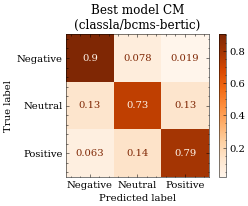

In [44]:
C_model_bertic = df.model_name == "classla/bcms-bertic"

subset = df[C_trained_on_train & C_evaled_on_test & C_model_bertic]
best_result = subset.iloc[subset.macroF1.argmax(), :]
y_true = best_result["y_true"]
y_pred = best_result["y_pred"]

import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
   normalize="true"
   )

plt.title("Best model CM\n(classla/bcms-bertic)")
plt.savefig()
plt.show()


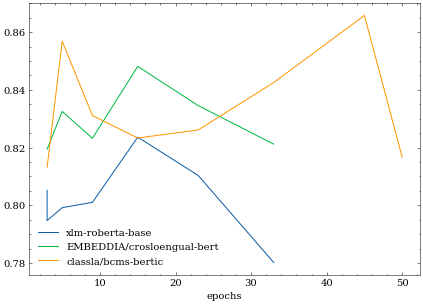

In [80]:
rezs = pd.read_csv("results3.csv")

rezs = rezs[rezs.batch_size == 8]

fig, ax = plt.subplots(figsize=(7,5))

for model_name in rezs.model_name.unique():
    rezs[rezs.model_name == model_name].plot(x="epochs", y="macroF1", ax=ax, label=model_name)
plt.show()

optimal epoch number for model xlm-roberta-base :  [15]
optimal epoch number for model EMBEDDIA/crosloengual-bert :  [15]
optimal epoch number for model classla/bcms-bertic :  [45]


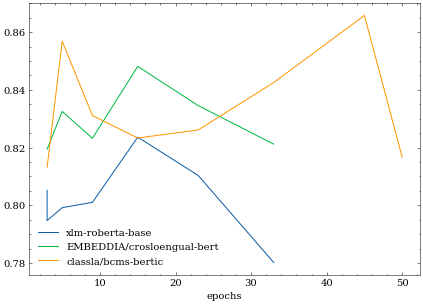

In [79]:
rezs = pd.read_csv("results3.csv")

rezs = rezs[rezs.batch_size == 8]

fig, ax = plt.subplots(figsize=(7,5))

for model_name in rezs.model_name.unique():
    rezs[rezs.model_name == model_name].plot(x="epochs", y="macroF1", ax=ax, label=model_name)
    max_f1 = rezs[rezs.model_name == model_name].macroF1.max()
    print("optimal epoch number for model", model_name, ": ", rezs[rezs.macroF1 == max_f1]["epochs"].tolist()  )
plt.show()

In [69]:
rezs[rezs.macroF1 == max_f1]["epochs"].values

array([5])

In [75]:
rezs

,model_name,model_type,epochs,batch_size,macroF1
0,xlm-roberta-base,xlmroberta,3,8,0.805195
1,xlm-roberta-base,xlmroberta,3,8,0.800266
2,EMBEDDIA/crosloengual-bert,bert,3,8,0.819474
3,xlm-roberta-base,xlmroberta,3,8,0.794719
4,classla/bcms-bertic,electra,3,8,0.813184
5,EMBEDDIA/crosloengual-bert,bert,5,8,0.832538
6,xlm-roberta-base,xlmroberta,5,8,0.799201
7,classla/bcms-bertic,electra,5,8,0.856857
8,EMBEDDIA/crosloengual-bert,bert,9,8,0.823234
9,xlm-roberta-base,xlmroberta,9,8,0.801040
